In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns



file_path = '/work/recent-grads.csv'
df = pd.read_csv(file_path)

X = df.drop(columns=['Median', 'P25th', 'P75th', 'Rank'])  # Excluding 'Median', 'P25th', 'P75th', 'Rank'
y = df['Median']

categorical_features = ['Major', 'Major_category']  # Update with actual categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


linear_model = LinearRegression()
ridge_model = Ridge(alpha=10, solver='auto', random_state=42)
random_forest_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42
)

ensemble = VotingRegressor(
    estimators=[
        ('lr', linear_model),
        ('ridge', ridge_model),
        ('rf', random_forest_model)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ensemble)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


Mean Squared Error: 30379958.186316635
R² Score: 0.6529812594587423


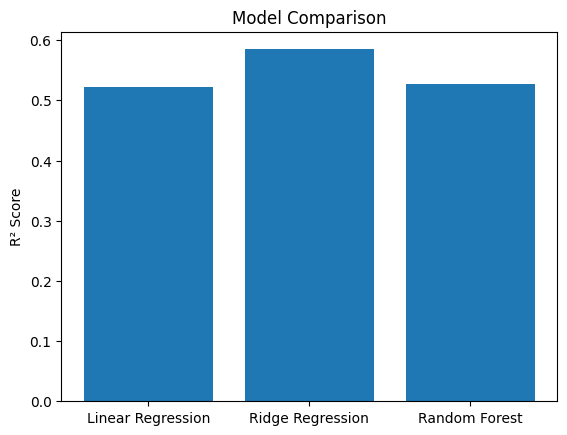

In [ ]:
# Creating a pipeline for each model
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge(alpha=10, solver='auto', random_state=42))])
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1, max_features='log2', random_state=42))])

# Fit and evaluate each model
pipeline_lr.fit(X_train, y_train)
pipeline_ridge.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

lr_r2 = r2_score(y_test, pipeline_lr.predict(X_test))
ridge_r2 = r2_score(y_test, pipeline_ridge.predict(X_test))
rf_r2 = r2_score(y_test, pipeline_rf.predict(X_test))

models_performance = {'Linear Regression': lr_r2, 'Ridge Regression': ridge_r2, 'Random Forest': rf_r2}


plt.bar(models_performance.keys(), models_performance.values())
plt.ylabel('R² Score')
plt.title('Model Comparison')
plt.show()



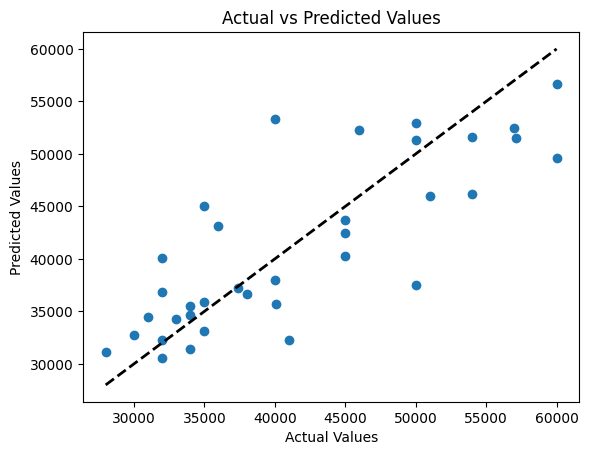

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()


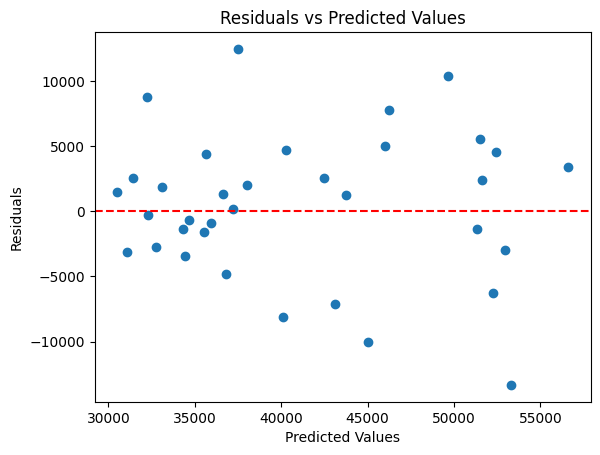

In [ ]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


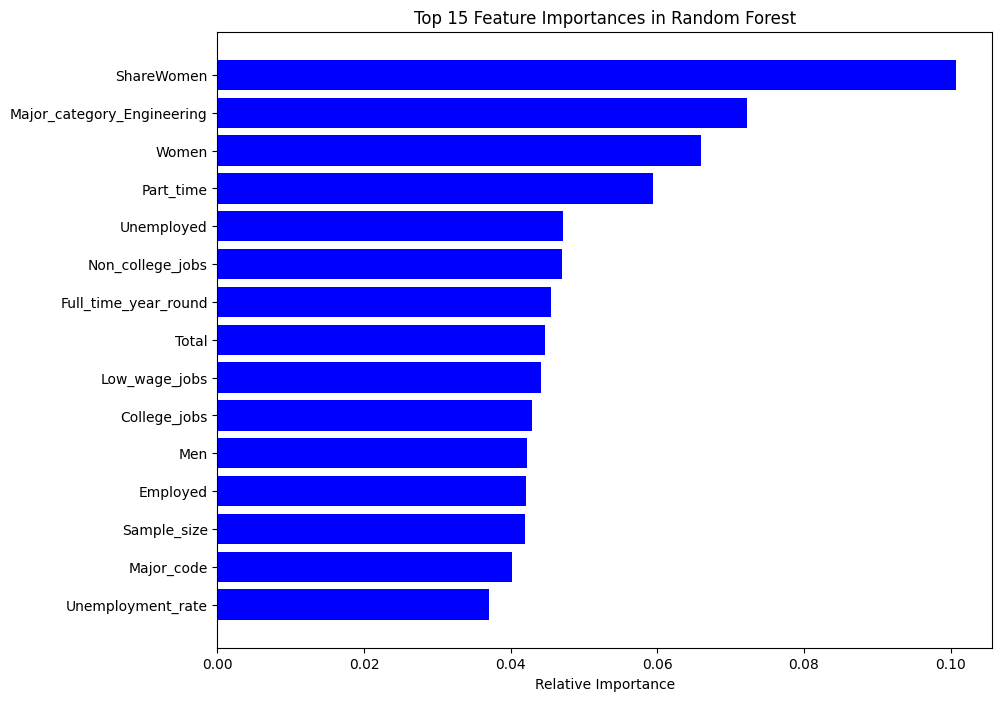

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_forest_model.fit(preprocessor.transform(X_train), y_train)


feature_importances = random_forest_model.feature_importances_
indices = np.argsort(feature_importances)[-15:]  # Get the indices of the top 20 features

# Combine feature names
all_features = numerical_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))

# Sort feature names based on their importance and select the top 20
sorted_feature_names = [all_features[i] for i in indices]

plt.figure(figsize=(10, 8))  # Adjust the size of the plot as needed
plt.title('Top 15 Feature Importances in Random Forest')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), sorted_feature_names)
plt.xlabel('Relative Importance')
plt.show()



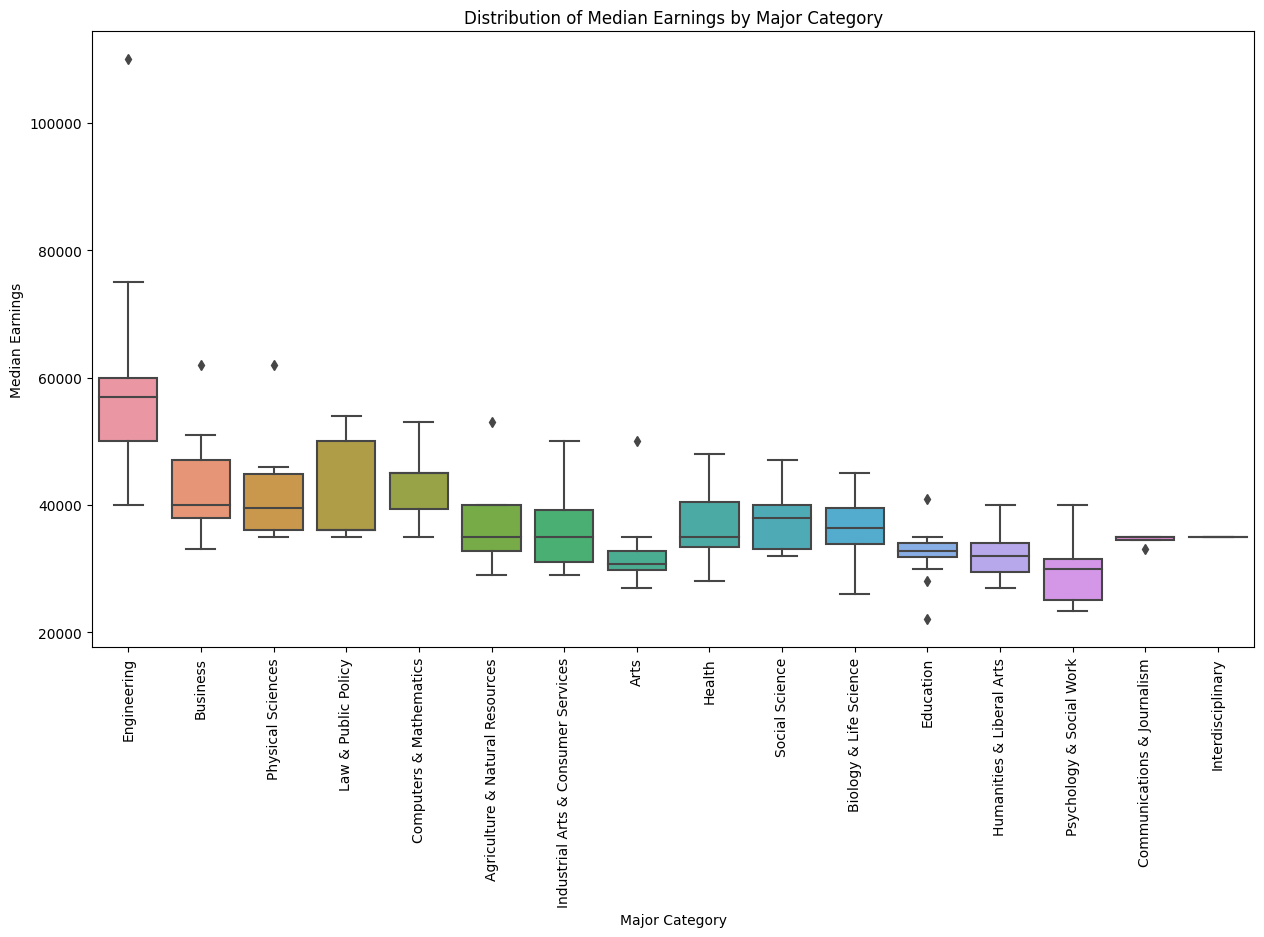

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='Major_category', y='Median', data=df)
plt.xticks(rotation=90)
plt.title('Distribution of Median Earnings by Major Category')
plt.xlabel('Major Category')
plt.ylabel('Median Earnings')
plt.show()

In [ ]:
# Example new major data (fill with your own values)
new_major_data = {
    'Major': ['Data Science at Berkeley'],
    'Major_code': [1],
    'Major_category': ['Computers & Mathematics'],
    'Total': [600],
    'Sample_size': [600],
    'Men': [300],
    'Women': [300],
    'ShareWomen': [0.5],
    'Employed': [580],
    'Full_time': [560],
    'Part_time': [20],
    'Full_time_year_round': [560],
    'Unemployed': [20],
    'Unemployment_rate': [0.03],
    'College_jobs': [560],  # Replace with actual value
    'Non_college_jobs': [0],  # Replace with actual value
    'Low_wage_jobs': [0]  # Replace with actual value
}

new_major_df = pd.DataFrame(new_major_data)


new_major_preprocessed = pipeline.named_steps['preprocessor'].transform(new_major_df)

predicted_median_earnings = pipeline.named_steps['regressor'].predict(new_major_preprocessed)

print(f"Predicted Median Earnings Adjusted for Inflation from 2011: {predicted_median_earnings[0] + (predicted_median_earnings[0]*0.368)}")




Predicted Median Earnings Adjusted for Inflation from 2011: 56739.621680102966


In [ ]:
print(f"Predicted Median Earnings Adjusted for Inflation and for California Cost of Living (42% higher): {(predicted_median_earnings[0] + (predicted_median_earnings[0]*0.368)*0.42) + predicted_median_earnings[0]}")

Predicted Median Earnings Adjusted for Inflation and for California Cost of Living (42% higher): 89363.24509289667


In [ ]:
df

,Rank,Major_code,Major,Total,Men,Women,Major_category,ShareWomen,Sample_size,Employed,...,Part_time,Full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th,College_jobs,Non_college_jobs,Low_wage_jobs
0,1,2419,PETROLEUM ENGINEERING,2339.0,2057.0,282.0,Engineering,0.120564,36,1976,...,270,1207,37,0.018381,110000,95000,125000,1534,364,193
1,2,2416,MINING AND MINERAL ENGINEERING,756.0,679.0,77.0,Engineering,0.101852,7,640,...,170,388,85,0.117241,75000,55000,90000,350,257,50
2,3,2415,METALLURGICAL ENGINEERING,856.0,725.0,131.0,Engineering,0.153037,3,648,...,133,340,16,0.024096,73000,50000,105000,456,176,0
3,4,2417,NAVAL ARCHITECTURE AND MARINE ENGINEERING,1258.0,1123.0,135.0,Engineering,0.107313,16,758,...,150,692,40,0.050125,70000,43000,80000,529,102,0
4,5,2405,CHEMICAL ENGINEERING,32260.0,21239.0,11021.0,Engineering,0.341631,289,25694,...,5180,16697,1672,0.061098,65000,50000,75000,18314,4440,972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,169,3609,ZOOLOGY,8409.0,3050.0,5359.0,Biology & Life Science,0.637293,47,6259,...,2190,3602,304,0.046320,26000,20000,39000,2771,2947,743
169,170,5201,EDUCATIONAL PSYCHOLOGY,2854.0,522.0,2332.0,Psychology & Social Work,0.817099,7,2125,...,572,1211,148,0.065112,25000,24000,34000,1488,615,82
170,171,5202,CLINICAL PSYCHOLOGY,2838.0,568.0,2270.0,Psychology & Social Work,0.799859,13,2101,...,648,1293,368,0.149048,25000,25000,40000,986,870,622
171,172,5203,COUNSELING PSYCHOLOGY,4626.0,931.0,3695.0,Psychology & Social Work,0.798746,21,3777,...,965,2738,214,0.053621,23400,19200,26000,2403,1245,308


In [ ]:
df.shape

(173, 21)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1ddad972-b280-4e94-9380-6dab3142ab79' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>